In [1]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


### Step 1: Load Data

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

In [3]:
data_dict = pd.read_csv("TOURNAMENT_DATA/DataDictionary - Sheet1.csv")
regional_games = pd.read_csv("TOURNAMENT_DATA/East Regional Games to predict - Sheet1.csv")
games_2022 = pd.read_csv("TOURNAMENT_DATA/games_2022 - games_2022.csv")
team_regions = pd.read_csv("TOURNAMENT_DATA/Team Region Groups - Sheet1.csv")

### Step 2: Data Cleaning & Preprocessing

In [4]:
regional_games.columns = regional_games.columns.str.lower().str.replace(" ", "_")
games_2022.columns = games_2022.columns.str.lower().str.replace(" ", "_")
team_regions.columns = team_regions.columns.str.lower().str.replace(" ", "_")

In [5]:
games_2022["game_date"] = pd.to_datetime(games_2022["game_date"], errors="coerce")

games_2022 = games_2022.merge(team_regions, on="team", how="left")

In [6]:
regional_games = regional_games.merge(
    team_regions.rename(columns={"team": "team_home", "region": "region_home"}),
    on="team_home",
    how="left"
)
regional_games = regional_games.merge(
    team_regions.rename(columns={"team": "team_away", "region": "region_away"}),
    on="team_away",
    how="left"
)

In [7]:
num_cols = ["largest_lead", "ot_length_min_tot", "rest_days", "attendance", "tz_dif_h_e", "prev_game_dist", "travel_dist"]
for col in num_cols:
    if col in games_2022.columns:
        games_2022[col].fillna(games_2022[col].median(), inplace=True)

/tmp/ipykernel_4802/306474479.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  games_2022[col].fillna(games_2022[col].median(), inplace=True)
/tmp/ipykernel_4802/306474479.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [8]:
print("Games 2022 - Summary Statistics:")
print(games_2022.describe())

Games 2022 - Summary Statistics:
                           game_date         fga_2         fgm_2  \
count                          10438  10438.000000  10438.000000   
mean   2022-01-09 17:45:51.561601792     58.764802     23.540908   
min              2021-11-09 00:00:00     25.000000      6.000000   
25%              2021-12-04 00:00:00     53.000000     20.000000   
50%              2022-01-15 00:00:00     58.000000     23.000000   
75%              2022-02-12 00:00:00     64.000000     27.000000   
max              2022-03-13 00:00:00    102.000000     56.000000   
std                              NaN      8.092935      5.607196   

              fga_3        fgm_3           fta           ftm           ast  \
count  10438.000000  10438.00000  10438.000000  10438.000000  10438.000000   
mean      19.051255      5.86348     16.076068     11.332631     12.967043   
min        1.000000      0.00000      0.000000      0.000000      0.000000   
25%       14.000000      4.00000     11.00

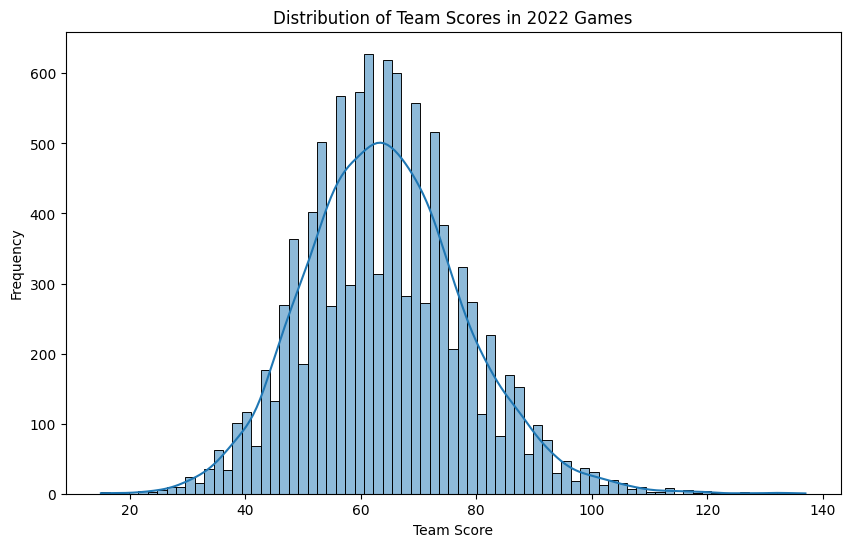

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(games_2022["team_score"], kde=True)
plt.title("Distribution of Team Scores in 2022 Games")
plt.xlabel("Team Score")
plt.ylabel("Frequency")
plt.show()

### Step 3: Feature Engineering

In [10]:
games_2022["fg_pct_2"] = games_2022["fgm_2"] / games_2022["fga_2"]
games_2022["fg_pct_3"] = games_2022["fgm_3"] / games_2022["fga_3"]
games_2022["ft_pct"] = games_2022["ftm"] / games_2022["fta"]

In [11]:
games_2022["point_diff"] = games_2022["team_score"] - games_2022["opponent_team_score"]

games_2022["win"] = (games_2022["team_score"] > games_2022["opponent_team_score"]).astype(int)

In [12]:
team_agg = games_2022.groupby("team").agg({
    "win": ["mean", "sum"],
    "team_score": "mean",
    "opponent_team_score": "mean",
    "fg_pct_2": "mean",
    "fg_pct_3": "mean",
    "ft_pct": "mean",
    "ast": "mean",
    "blk": "mean",
    "stl": "mean",
    "tov": "mean",
    "point_diff": "mean"
})

In [13]:
team_agg.columns = ["_".join(col).strip() for col in team_agg.columns.values]
team_agg = team_agg.reset_index()
team_agg.rename(columns={"win_mean": "win_percentage", "win_sum": "total_wins"}, inplace=True)
team_agg = team_agg.merge(team_regions, on="team", how="left")

In [14]:
print("\nTop 5 Teams by Win Percentage:")
print(team_agg.sort_values("win_percentage", ascending=False).head())


Top 5 Teams by Win Percentage:
                                  team  win_percentage  total_wins  \
496                unc_pembroke_braves        1.000000           1   
460  texas_am_international_dustdevils        1.000000           1   
96                        coker_cobras        1.000000           1   
157               freed_hardeman_lions        1.000000           1   
417           south_carolina_gamecocks        0.935484          29   

     team_score_mean  opponent_team_score_mean  fg_pct_2_mean  fg_pct_3_mean  \
496        65.000000                 45.000000       0.431034       0.333333   
460        68.000000                 55.000000       0.426230       0.352941   
96         51.000000                 44.000000       0.271186       0.227273   
157        71.000000                 62.000000       0.500000       0.363636   
417        71.290323                 51.677419       0.438017       0.315578   

     ft_pct_mean   ast_mean  blk_mean   stl_mean   tov_mean  point

### Step 4: Use Elo Ranking System

In [15]:
all_teams = pd.concat([games_2022["team"], games_2022["team"]]).unique()
elo_ratings = {team: 1500 for team in all_teams}

In [16]:
def expected_score(rating_a, rating_b):
    """Calculate expected score for team A against team B."""
    return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))

In [17]:
grouped_games = games_2022.groupby("game_id")
k = 20  

In [18]:
for game_id, group in grouped_games:
    if group.shape[0] != 2:
        continue  
    if "home" in group["home_away"].values and "away" in group["home_away"].values:
        home_row = group[group["home_away"] == "home"].iloc[0]
        away_row = group[group["home_away"] == "away"].iloc[0]
    else:
        home_row = group.iloc[0]
        away_row = group.iloc[1]
    
    home_team = home_row["team"]
    away_team = away_row["team"]
    home_score = home_row["team_score"]
    away_score = away_row["team_score"]
    
    outcome_home = 1 if home_score > away_score else 0
    outcome_away = 1 - outcome_home
    
    expected_home = expected_score(elo_ratings[home_team], elo_ratings[away_team])
    expected_away = expected_score(elo_ratings[away_team], elo_ratings[home_team])
    
    elo_ratings[home_team] += k * (outcome_home - expected_home)
    elo_ratings[away_team] += k * (outcome_away - expected_away)

In [19]:
team_agg["elo_rating"] = team_agg["team"].apply(lambda t: elo_ratings.get(t, 1500))

In [20]:
regional_games["elo_home"] = regional_games["team_home"].apply(lambda t: elo_ratings.get(t, 1500))
regional_games["elo_away"] = regional_games["team_away"].apply(lambda t: elo_ratings.get(t, 1500))
regional_games["expected_home"] = 1 / (1 + 10 ** ((regional_games["elo_away"] - regional_games["elo_home"]) / 400))
regional_games["predicted_winning_%_elo"] = regional_games["expected_home"]

In [21]:
print("\nRegional Games Predictions using ELO:")
print(regional_games[["game_id", "team_home", "team_away", "predicted_winning_%_elo"]].head())


Regional Games Predictions using ELO:
    game_id          team_home                 team_away  \
0  G_East_1  rhode_island_rams  north_carolina_tar_heels   
1  G_East_2  nc_state_wolfpack         rhode_island_rams   
2  G_East_3  nc_state_wolfpack  north_carolina_tar_heels   
3  G_East_4     liberty_flames            bucknell_bison   
4  G_East_5     drexel_dragons        delaware_blue_hens   

   predicted_winning_%_elo  
0                 0.503744  
1                 0.624997  
2                 0.628500  
3                 0.601198  
4                 0.499602  


In [22]:
team_agg["combined_rank_score"] = team_agg["win_percentage"] * 0.5 + (team_agg["elo_rating"] / 3000) * 0.5
team_agg.sort_values("combined_rank_score", ascending=False, inplace=True)

In [23]:
print("\nTeam Rankings based on Combined Score:")
print(team_agg[["team", "win_percentage", "elo_rating", "combined_rank_score"]].head())


Team Rankings based on Combined Score:
                                  team  win_percentage   elo_rating  \
417           south_carolina_gamecocks        0.935484  1707.951850   
496                unc_pembroke_braves        1.000000  1510.000000   
157               freed_hardeman_lions        1.000000  1510.000000   
460  texas_am_international_dustdevils        1.000000  1509.171721   
96                        coker_cobras        1.000000  1506.545634   

     combined_rank_score  
417             0.752401  
496             0.751667  
157             0.751667  
460             0.751529  
96              0.751091  


### Step 5: Train Logistic Regression Model

In [24]:
games_home = games_2022[games_2022["home_away"] == "home"][["game_id", "team", "win"]].rename(columns={"team": "team_home", "win": "win_home"})
games_away = games_2022[games_2022["home_away"] == "away"][["game_id", "team", "win"]].rename(columns={"team": "team_away", "win": "win_away"})

In [25]:
matchups = pd.merge(games_home, games_away, on="game_id")

features = ['win_percentage', 'team_score_mean', 'fg_pct_2_mean', 'fg_pct_3_mean', 
            'ft_pct_mean', 'ast_mean', 'blk_mean', 'stl_mean', 'tov_mean', 'point_diff_mean', 'elo_rating']

In [26]:
matchups = matchups.merge(team_agg[['team'] + features], left_on='team_home', right_on='team', how='left') \
                   .drop("team", axis=1) \
                   .rename(columns={f: f"{f}_home" for f in features})

matchups = matchups.merge(team_agg[['team'] + features], left_on='team_away', right_on='team', how='left') \
                   .drop("team", axis=1) \
                   .rename(columns={f: f"{f}_away" for f in features})

In [27]:
for f in features:
    matchups[f + "_diff"] = matchups[f + "_home"] - matchups[f + "_away"]

In [28]:
X = matchups[[f + "_diff" for f in features]]
y = matchups["win_home"]

In [49]:
X

,win_percentage_diff,team_score_mean_diff,fg_pct_2_mean_diff,fg_pct_3_mean_diff,ft_pct_mean_diff,ast_mean_diff,blk_mean_diff,stl_mean_diff,tov_mean_diff,point_diff_mean_diff,elo_rating_diff
0,-0.142857,-4.607143,-0.012945,-0.031344,0.075898,2.142857,2.107143,0.321429,2.428571,-3.000000,-54.357023
1,-0.335484,-0.990323,0.016957,0.056755,0.057828,-0.760215,-5.907527,-0.723656,0.088172,-16.246237,-147.335833
2,0.175269,-0.597849,-0.001368,-0.037111,-0.073394,3.445161,2.967742,-2.609677,1.993548,4.341935,73.030848
3,0.209524,6.819048,0.027359,0.055941,0.057131,-0.014286,-0.428571,0.435714,0.235714,7.578571,86.193145
4,-0.161290,3.806452,-0.004441,0.025003,0.041774,-1.903226,-1.000000,1.064516,-5.903226,-1.709677,-64.198911
...,...,...,...,...,...,...,...,...,...,...,...
5214,0.206044,4.241758,0.030673,-0.016583,0.017759,2.884615,2.112637,-0.873626,-0.799451,11.373626,75.843062
5215,-0.350575,0.993103,-0.027999,-0.009428,-0.117540,-0.716092,0.150575,-0.862069,3.947126,-17.871264,-134.499916
5216,-0.312903,-6.956989,-0.028493,-0.076158,-0.027751,-2.552688,-0.484946,-0.016129,3.624731,-11.887097,-154.249616
5217,-0.366097,-23.925926,-0.071856,-0.073183,-0.036986,-6.105413,-0.437322,-4.393162,5.938746,-21.594017,-129.531080


In [31]:
print("Missing values in X before imputation:")
print(X.isnull().sum())

Missing values in X before imputation:
win_percentage_diff     0
team_score_mean_diff    0
fg_pct_2_mean_diff      0
fg_pct_3_mean_diff      0
ft_pct_mean_diff        1
ast_mean_diff           0
blk_mean_diff           0
stl_mean_diff           0
tov_mean_diff           0
point_diff_mean_diff    0
elo_rating_diff         0
dtype: int64


In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [35]:
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [36]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_imputed, y_train)

LogisticRegression(max_iter=1000)

In [37]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nLogistic Regression Model - Accuracy: {accuracy:.3f}, ROC AUC: {roc_auc:.3f}")


Logistic Regression Model - Accuracy: 0.787, ROC AUC: 0.869


/home/devmonkeyy/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/devmonkeyy/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


### Step 6: Prediction

In [38]:
regional_games = regional_games.merge(team_agg[['team'] + features], left_on='team_home', right_on='team', how='left') \
                               .drop("team", axis=1) \
                               .rename(columns={f: f"{f}_home" for f in features})
regional_games = regional_games.merge(team_agg[['team'] + features], left_on='team_away', right_on='team', how='left') \
                               .drop("team", axis=1) \
                               .rename(columns={f: f"{f}_away" for f in features})

In [39]:
for f in features:
    regional_games[f+ "_diff"] = regional_games[f + "_home"] - regional_games[f + "_away"]

In [40]:
predictor_cols = [f + "_diff" for f in features]
regional_games["predicted_prob_model"] = model.predict_proba(regional_games[predictor_cols])[:, 1]

/home/devmonkeyy/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [48]:
print("\nRegional Games Predictions using Logistic Regression Model:")
print(regional_games[["game_id", "team_home", "team_away", "predicted_prob_model"]][:10])


Regional Games Predictions using Logistic Regression Model:
     game_id                   team_home                 team_away  \
0   G_East_1           rhode_island_rams  north_carolina_tar_heels   
1   G_East_2           nc_state_wolfpack         rhode_island_rams   
2   G_East_3           nc_state_wolfpack  north_carolina_tar_heels   
3   G_East_4              liberty_flames            bucknell_bison   
4   G_East_5              drexel_dragons        delaware_blue_hens   
5   G_East_6   massachusetts_minutewomen          princeton_tigers   
6   G_East_7               buffalo_bulls     stony_brook_seawolves   
7   G_East_8             fairfield_stags             towson_tigers   
8   G_East_9               uconn_huskies  campbell_fighting_camels   
9  G_East_10  american_university_eagles            columbia_lions   

   predicted_prob_model  
0              0.574693  
1              0.854861  
2              0.827633  
3              0.836192  
4              0.713627  
5           